<H3> In this notebooke we actually create the VAE and train on the stock chart images

In [1]:
import torch
import numpy as np

data_input_dir='dataset//'
image_count = 1

#load image_count images as np arrays and convert to torch tensor
dataset = torch.tensor(np.asarray([np.load(data_input_dir+'0-'+str(i)+'.npy') for i in range(image_count)]),dtype=torch.float)
print(dataset.shape)






torch.Size([1, 3, 100, 104])


<h3>Dataloader to create batches and shuffle the data

In [2]:
batch_size=10
#sampler= torch.utils.data.RandomSampler(dataset)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)

In [3]:
class AE(torch.nn.Module):
  def __init__(self, channels):
    super(AE, self).__init__()
    self.channels=channels
    self.encoder = torch.nn.Sequential(
        torch.nn.Conv2d(3,channels,kernel_size=(1,1),stride=(1,1)),
        torch.nn.ReLU(),
        torch.nn.Conv2d(channels,channels*2,kernel_size=(2,2), stride=(2,2)),
        torch.nn.ReLU(),
        torch.nn.Conv2d(channels*2,channels*2,kernel_size=(1,1), stride=(1,1)),
        torch.nn.ReLU(),
      )

    self.bottleneck = torch.nn.Sequential(
        torch.nn.Linear(in_features=(channels*2)*50*52, out_features=2_000),
        torch.nn.ReLU(),
        torch.nn.Linear(in_features=2_000, out_features=(channels*2)*50*52),
        torch.nn.ReLU(),
      )

    self.decoder = torch.nn.Sequential(        
        torch.nn.ConvTranspose2d(channels*2,channels*2,kernel_size=(1,1), stride=(1,1)),
        torch.nn.ReLU(),
        torch.nn.ConvTranspose2d(channels*2,channels,kernel_size=(2,2), stride=(2,2)),
        torch.nn.ReLU(),
        torch.nn.ConvTranspose2d(channels,3,kernel_size=(1,1),stride=(1,1)),
    )

  def forward(self, x):
    latent = self.encoder(x)
    squished= self.bottleneck(torch.flatten(latent, start_dim=1, end_dim=-1))
    squished= torch.reshape(squished, (-1,self.channels*2,50,52))
    x_out = self.decoder(squished)
    return x_out

model = AE(channels=25)



In [4]:
torch.cuda.empty_cache()

In [5]:
# Define the loss function and optimizer
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.025)

loss_list=[]
# Train the model
for epoch in range(900):
    for idx, (images) in enumerate(data_loader):
        images.to('cuda')
        output = model(images).to('cuda')
        loss = criterion(output, images.to('cuda'))

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_list.append(loss.item())

    # Print loss
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/10], Loss: {loss.item():.4f}')


Epoch [10/10], Loss: 0.0810
Epoch [20/10], Loss: 0.0740
Epoch [30/10], Loss: 0.0699
Epoch [40/10], Loss: 0.0675
Epoch [50/10], Loss: 0.0664
Epoch [60/10], Loss: 0.0662


KeyboardInterrupt: 

Text(0.5, 1.0, 'Loss Curve')

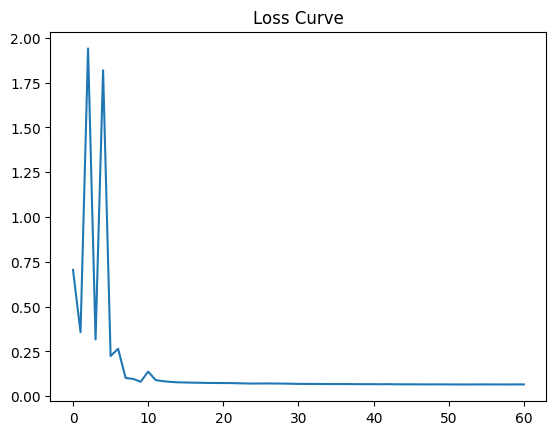

In [6]:
import matplotlib.pyplot as plt
plt.plot(loss_list)
plt.title('Loss Curve')

In [7]:
torch.max(output[0])

tensor(356.0409, device='cuda:0', grad_fn=<MaxBackward1>)

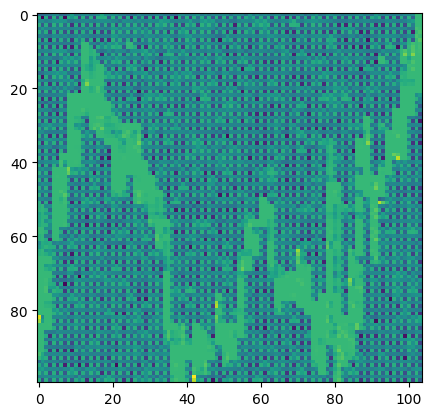

In [8]:
import matplotlib.pyplot as plt
for i in range(1):
    plt.figure()
    plt.imshow(output[i][2].to('cpu').detach())

In [9]:
np.save('test.npy',np.round(torch.sigmoid(output[0,:,:,:].to('cpu').detach())))
np.save('test_real.npy',np.round(torch.sigmoid(images[0,:,:,:].to('cpu').detach())))

In [ ]:
flatten = torch.nn.Flatten()
a = torch.nn.Conv2d(3,3,kernel_size=(1,1),stride=(1,1))
b = torch.nn.Conv2d(3,3,kernel_size=(2,2), stride=(2,2))
c = torch.nn.Conv2d(3,3,kernel_size=(1,1), stride=(1,1))
d = torch.nn.Linear(in_features=3*50*52, out_features=3*50*52)

out_0 = a(dataset)
#print(out_0.shape)
out_1 = b(out_0)
#print(out_1.shape)
out_2 = c(out_1)
#print(out_2.shape)
flat_out_2 = flatten(out_2)
#print(flat_out_2.shape)
out_3 = d(flat_out_2)
print(out_0.shape, out_1.shape, out_2.shape, flat_out_2.shape, out_3.shape)

e = torch.nn.Linear(in_features=3*50*52, out_features=3*50*52)
f = torch.nn.ConvTranspose2d(3,3,kernel_size=(1,1), stride=(1,1))
g = torch.nn.ConvTranspose2d(3,3,kernel_size=(2,2), stride=(2,2))
h = torch.nn.ConvTranspose2d(3,3,kernel_size=(1,1),stride=(1,1))

up_0 = e(out_3)
up_0 = torch.reshape(up_0,(-1,3,50,52))
up_1 = f(up_0)
up_2 = g(up_1)
up_3 = h(up_2)
print(out_3.shape, up_0.shape, up_1.shape, up_2.shape, up_3.shape)




torch.Size([100, 3, 100, 104]) torch.Size([100, 3, 50, 52]) torch.Size([100, 3, 50, 52]) torch.Size([100, 7800]) torch.Size([100, 7800])
torch.Size([100, 7800]) torch.Size([100, 3, 50, 52]) torch.Size([100, 3, 50, 52]) torch.Size([100, 3, 100, 104]) torch.Size([100, 3, 100, 104])


In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(out_0[9,0,:,:].detach())
plt.figure()
plt.imshow(out_1[9,0,:,:].detach())
plt.figure()
plt.imshow(out_2[9,0,:,:].detach())
plt.figure(figsize=(10,10))
#plt.imshow(flat_out_2[0,:].detach())
plt.imshow(out_3.detach())

In [ ]:
plt.figure()
plt.imshow(up_0[0,0,:,:].detach())
plt.figure()
plt.imshow(up_1[0,0,:,:].detach())
plt.figure()
plt.imshow(up_2[0,0,:,:].detach())
plt.figure()
plt.imshow(up_3[0,0,:,:].detach())